---
title: Fiori
subtitle: Análisis información
author: Jefe confiabilidad
date: 2025-03-21
---

In [ ]:
from narwhals import DataFrame

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import sys
from pathlib import Path


import pandas as pd
import polars as pl
import dagster as dg
from kdags.resources.dplyr import *
from kdags.resources.tidyr import *
from io import BytesIO
import pdfplumber

# from datetime import datetime
import re
import os
from kdags.definitions import *
from kdags.readr import *
import numpy as np

context = dg.build_asset_context()
from itables import init_notebook_mode, show

init_notebook_mode(all_interactive=True)

from kdags.resources.ggplot import *
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from datetime import datetime

equipments_names = MasterData.equipments()["equipment_name"].to_list()


def create_equipment_completeness_plot(
    df, date_col="record_dt", equipment_col="equipment_name"
):
    """
    Create a visualization of data completeness by equipment and date using enhanced GGPrism theme.

    Parameters:
    -----------
    df : polars.DataFrame or pandas.DataFrame
        DataFrame containing equipment and date information
    date_col : str
        Name of the date column
    equipment_col : str
        Name of the equipment column

    Returns:
    --------
    tuple: (fig, ax) - matplotlib figure and axes objects
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.patches import Circle
    import polars as pl
    from kdags.resources.ggplot.ggprism import GGPrism
    import matplotlib.dates as mdates

    # Convert to pandas for easier date handling if using polars
    if isinstance(df, pl.DataFrame):
        pdf = df.to_pandas()
    else:
        pdf = df
    pdf = pdf.loc[pdf[equipment_col].isin(equipments_names)]
    # Ensure date column is datetime
    pdf[date_col] = pd.to_datetime(pdf[date_col])
    pdf = pdf.loc[pdf[date_col] <= datetime.now()]
    # Create a month period column
    pdf["month"] = pdf[date_col].dt.to_period("M")

    # Get unique equipment and months
    equipments = sorted(pdf[equipment_col].unique())
    months = sorted(pdf["month"].unique())

    # Create a pivot table to check data availability
    availability = pdf.groupby([equipment_col, "month"]).size().unstack(fill_value=0)
    availability = (availability > 0).astype(int)

    # Initialize GGPrism theme with custom settings
    theme = GGPrism(base_size=14, base_fontface="bold")

    # Create figure with appropriate aspect ratio
    fig_width = max(
        12, len(months) * 0.25 + 2
    )  # Adjust width based on number of months
    fig_height = max(
        8, len(equipments) * 0.25 + 2
    )  # Adjust height based on number of equipment
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    # Apply GGPrism theme to the plot
    theme.apply_theme(ax)

    # Generate an array for coloring
    n_equip = len(equipments)
    n_months = len(months)
    has_data_array = np.zeros((n_equip, n_months))

    for i, equipment in enumerate(sorted(availability.index)):
        for j, month in enumerate(availability.columns):
            if equipment in availability.index:
                has_data = availability.loc[equipment, month]
                has_data_array[i, j] = has_data

    # Use enhanced GGPrism colors for the circles
    available_color = "#077E97"  # Bright blue from GGPrism winter_bright palette
    missing_color = "#800080"  # Purple from GGPrism winter_bright palette

    # Set circle size based on plot dimensions
    circle_size = min(0.35, 600 / (n_equip * n_months))

    # Create a scatter plot with circles
    for i in range(n_equip):
        for j in range(n_months):
            has_data = has_data_array[i, j]

            # Draw a circle - filled if data exists, empty if missing
            if has_data:
                circle = Circle((j, i), circle_size, color=available_color, alpha=0.8)
            else:
                circle = Circle(
                    (j, i),
                    circle_size,
                    fill=False,
                    edgecolor=missing_color,
                    linestyle="--",
                    linewidth=1.2,
                )

            ax.add_patch(circle)

    # Set up axis labels
    ax.set_xticks(np.arange(n_months))
    ax.set_yticks(np.arange(n_equip))

    # Format month labels - improve readability
    month_labels = [m.strftime("%Y-%m") for m in months]

    # If we have many months, only show some labels to avoid overcrowding
    if len(months) > 24:
        # Show every nth label
        n = max(1, len(months) // 12)
        shown_indices = list(range(0, len(months), n))
        empty_labels = [""] * len(months)
        for idx in shown_indices:
            if idx < len(month_labels):
                empty_labels[idx] = month_labels[idx]
        month_labels = empty_labels

    ax.set_xticklabels(month_labels, rotation=45, ha="right")

    # Apply GGPrism styling to axis labels
    for tick in ax.get_xticklabels():
        tick.set_fontweight(theme.base_fontface)
        tick.set_color(theme.FIXED_COLORS["axis_color"])
        tick.set_fontsize(theme.axis_text_size)

    for tick in ax.get_yticklabels():
        tick.set_fontweight(theme.base_fontface)
        tick.set_color(theme.FIXED_COLORS["axis_color"])
        tick.set_fontsize(theme.axis_text_size)

    ax.set_yticklabels(sorted(availability.index))

    # Set axis limits to ensure circles are fully visible
    ax.set_xlim(-0.5, n_months - 0.5)
    ax.set_ylim(-0.5, n_equip - 0.5)

    # Add subtle grid
    ax.grid(which="both", color="#EEEEEE", linestyle="-", linewidth=0.5, alpha=0.7)

    # Create legend elements
    legend_elements = [
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor=available_color,
            markersize=12,
        ),
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor="w",
            markeredgecolor=missing_color,
            markersize=12,
            markeredgewidth=1.2,
        ),
    ]

    # Add legend with GGPrism styling
    legend = ax.legend(
        legend_elements,
        ["Data Available", "Data Missing"],
        loc="upper right",
        frameon=True,
    )

    # Apply GGPrism styling to legend
    legend.get_frame().set_linewidth(theme.base_line_size)
    legend.get_frame().set_edgecolor(theme.FIXED_COLORS["axis_color"])

    # Make legend text regular weight
    for text in legend.get_texts():
        text.set_color(theme.FIXED_COLORS["axis_color"])
        text.set_fontsize(theme.legend_text_size)

    # Use GGPrism title and label styling
    ax.set_title(
        "Disponibilidad mensual de datos",
        fontsize=theme.title_size,
        fontweight=theme.base_fontface,
        color=theme.FIXED_COLORS["plot_title_color"],
        pad=20,
    )

    ax.set_xlabel(
        "Mes",
        fontsize=theme.axis_title_size,
        fontweight=theme.base_fontface,
        color=theme.FIXED_COLORS["axis_title_color"],
        labelpad=15,
    )

    ax.set_ylabel(
        "Equipo",
        fontsize=theme.axis_title_size,
        fontweight=theme.base_fontface,
        color=theme.FIXED_COLORS["axis_title_color"],
        labelpad=15,
    )

    # Adjust layout
    plt.tight_layout()

    # Add a bit more padding at the top for the title
    plt.subplots_adjust(top=0.95)

    return fig

# Órdenes de servicio

Data con el detalle de texto de las órdenes de servicio.

Disponible en el siguiente link:

https://globalkomatsu.sharepoint.com/sites/KCHCLSP00022/Shared%20Documents/01.%20%C3%81REAS%20KCH/1.6%20CONFIABILIDAD/CAEX/ANTECEDENTES/MAINTENANCE/WORK_ORDERS_HISTORY/work_order_history.xlsx

In [4]:
work_order_history_df = Readr.Maintenance.read_work_order_history()

In [17]:
work_order_history_df.dropna(subset=["task_text"])

ot                               description           priority  \
60    416237046        NMC Cambio Cilindro de Levante Izq    Sched in Period   
71    416292108  Fisura Chasis Superior Interior Lado Izq    Sched in Period   
72    416292109    Cambiar Bisagras Puertas De Emergencia    Sched in Period   
81    416374312         Reparación de Fisura Caja de Aire    Sched in Period   
84    416416097        MC: Cambiar Rejilla ducto scoop MT    Sched in Period   
...         ...                                       ...                ...   
1627  528819505    28D Mec CCE Insp Crit Incen Mtor TK880  Sched Day Defined   
1634  528893661            168D Mec Serv Sist Incen TK880  Sched Day Defined   
1635  528894084             112D MC Medi Alte Princ TK880  Sched Day Defined   
1636  528894117    28D Mec CCE Insp Crit Incen Mtor TK880  Sched Day Defined   
1647  528949012    6000H Mec Reem  Grupo de Control TK880  Sched Day Defined   

     start_date   end_date                             Revisión  \
60   2021-06-28 2021-06-28  WK 26: 28.06.21 - 04.07.21 (Y21W26)   
71   2021-03-22 2021-03-23  WK 12: 22.03.21 - 28.03.21 (Y21W12)   
72   2021-10-04 2021-10-05  WK 40: 04.10.21 - 10.10.21 (Y21W40)   
81   2021-01-25 2021-01-26  WK 04: 25.01.21 - 31.01.21 (Y21W04)   
84   2021-01-25 2021-01-25  WK 04: 25.01.21 - 31.01.21 (Y21W04)   
...         ...        ...                                  ...   
1627 2025-01-15 2025-01-15  WK 03: 13.01.25 - 19.01.25 (Y25W03)   
1634 2025-02-16 2025-02-16  WK 07: 10.02.25 - 16.02.25 (Y25W07)   
1635 2025-02-16 2025-02-16  WK 07: 10.02.25 - 16.02.25 (Y25W07)   
1636 2025-02-16 2025-02-16  WK 07: 10.02.25 - 16.02.25 (Y25W07)   
1647 2024-11-29 2024-11-30  WK 48: 25.11.24 - 01.12.24 (Y24W48)   

     equipment_name              updated_at  \
60            TK320 2025-02-05 10:02:41.344   
71            TK320 2025-02-05 09:30:44.563   
72            TK320 2025-02-05 10:32:33.987   
81            TK320 2025-02-05 09:15:32.077   
84            TK320 2025-02-05 09:15:55.050   
...             ...                     ...   
1627          TK880 2025-02-06 15:59:31.885   
1634          TK880 2025-02-06 16:06:25.153   
1635          TK880 2025-02-06 16:06:46.788   
1636          TK880 2025-02-06 16:07:08.930   
1647          TK880 2025-02-06 15:42:30.056   

                                              task_text  \
60    08.08.2020 21:59:03 UTC Edson Monterrey (MONTE...   
71    10.09.2020 22:08:19 UTC Mario Herrera (HERRMA)...   
72    11.09.2020 13:36:28 UTC Fernando Carvajal (CAR...   
81    03.11.2020 19:29:38 UTC Patricio Rodriguez (RO...   
84    30.11.2020 18:53:30 UTC Luis Olivares (KP9OLIL...   
...                                                 ...   
1627  15.01.2025 16:58:29 UTC (COLLPAT)\n Se acude a...   
1634                      No hay texto largo disponible   
1635                      No hay texto largo disponible   
1636                      No hay texto largo disponible   
1647  02.12.2024 21:05:26 UTC (CAMPPA)\n Aprobada po...   

                                              documents  
60                                                   []  
71                                                   []  
72    ['AA15108 EGRESS GATE HINGES AND LATCHES RATTL...  
81                                                   []  
84                              ['20201129_135436.jpg']  
...                                                 ...  
1627    ['440419571.pdf', 'Puntos calientes TK880.PDF']  
1634                                                 []  
1635                                                 []  
1636                                                 []  
1647                                                 []  

[59422 rows x 10 columns]

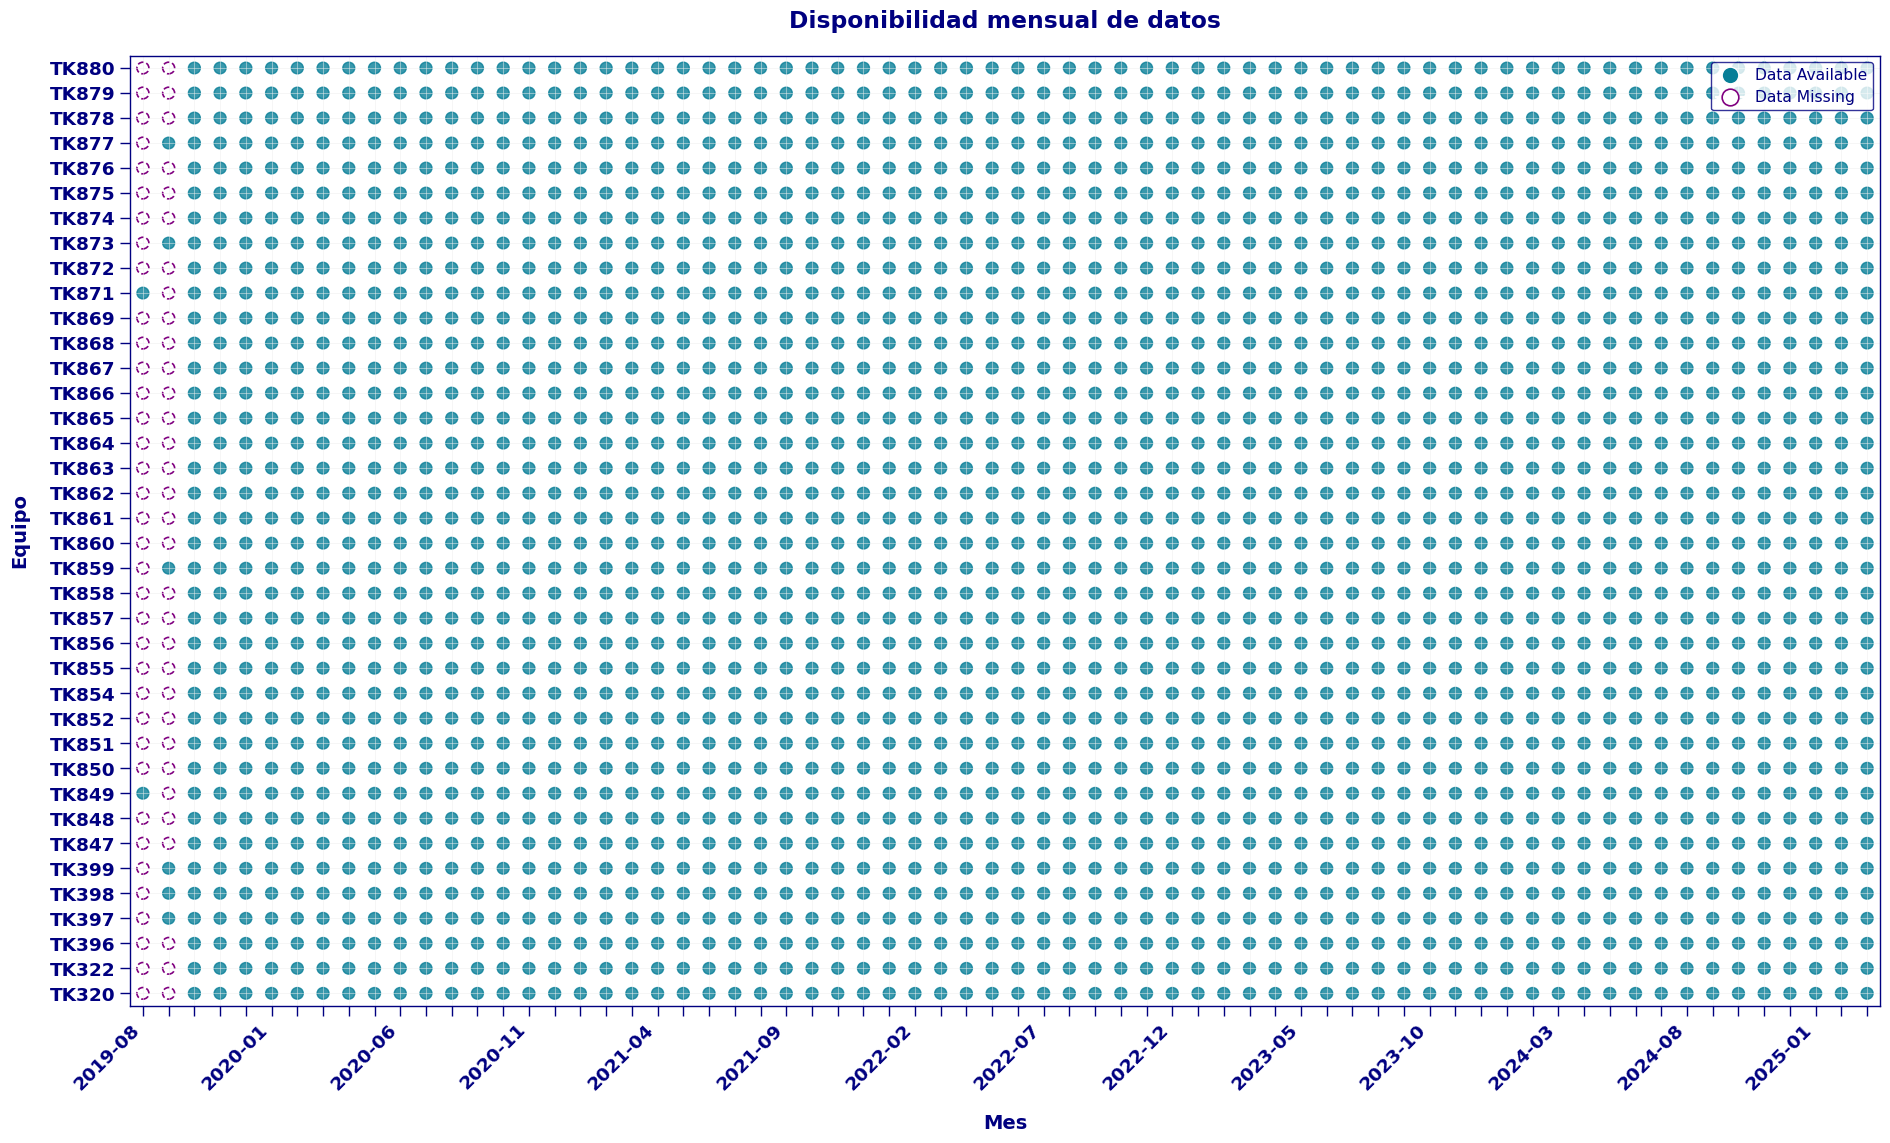

In [18]:
fig = create_equipment_completeness_plot(
    work_order_history_df, date_col="start_date", equipment_col="equipment_name"
)

# Pautas de Mantenimiento

Contiene el detalle de las pautas de mantenimiento.

Disponible en el siguiente link:

https://globalkomatsu.sharepoint.com/sites/KCHCLSP00022/Shared%20Documents/01.%20%C3%81REAS%20KCH/1.6%20CONFIABILIDAD/CAEX/ANTECEDENTES/MAINTENANCE/PM_HISTORY/pm_history.xlsx

In [14]:
pm_history_df = Readr.Maintenance.read_pm_history()

In [15]:
pm_history_df

pm_id   pm_status  work_order_number          start_date  \
0      30193   completed          525425673 2022-12-09 10:05:00   
1      30188   completed          525425682 2022-12-10 16:56:00   
2      44431   completed          526511572 2023-06-25 00:40:00   
3      28971   completed          525425761 2022-11-10 03:00:00   
4      16699  incomplete           20221804 2022-04-18 14:59:00   
...      ...         ...                ...                 ...   
8342  184868   completed          528533156 2025-01-28 10:06:00   
8343  184860   completed          528533157 2025-01-28 10:22:00   
8344  185062   completed          528484351 2025-01-29 05:02:00   
8345  192265   completed          528537062 2025-02-10 21:21:00   
8346  192266   completed          528537063 2025-02-11 08:18:00   

                end_date                           summary_content  \
0    2022-12-09 10:05:00          72D Mec CCE Serv PM Paso 6 TK285   
1    2022-12-10 16:56:00          72D Mec Serv Pre PM Paso 6 TK285   
2    2023-06-25 00:40:00           28D Mec Serv Sist Incen - TK286   
3    2022-11-10 03:00:00          24D Mec CCE Serv PM Paso 2 TK291   
4    2022-04-18 14:59:00             112D Mec Serv PM Paso 8 TK320   
...                  ...                                       ...   
8342 2025-01-28 10:06:00  12000H Mech Repl Cyli Ster 980E5 - CEX74   
8343 2025-01-28 10:22:00  12000H Mech Repl Cyli Ster 980E5 - CEX74   
8344 2025-01-29 05:02:00  28D Svce PM Autonomía Step 2 CCE - CEX74   
8345 2025-02-10 21:21:00                   14D Svce PM Pre - CEX74   
8346 2025-02-11 08:18:00         14D Svce PM Pre Autonomía - CEX74   

     equipment_name site_name  \
0             TK285       MEL   
1             TK285       MEL   
2             TK286       MEL   
3             TK291       MEL   
4             TK320       MEL   
...             ...       ...   
8342          CEX74    SPENCE   
8343          CEX74    SPENCE   
8344          CEX74    SPENCE   
8345          CEX74    SPENCE   
8346          CEX74    SPENCE   

                                        raw_file_path  \
0      abfs://bhp-raw-data/FIORI/PM_REPORTS/30193.pdf   
1      abfs://bhp-raw-data/FIORI/PM_REPORTS/30188.pdf   
2      abfs://bhp-raw-data/FIORI/PM_REPORTS/44431.pdf   
3      abfs://bhp-raw-data/FIORI/PM_REPORTS/28971.pdf   
4      abfs://bhp-raw-data/FIORI/PM_REPORTS/16699.pdf   
...                                               ...   
8342  abfs://bhp-raw-data/FIORI/PM_REPORTS/184868.pdf   
8343  abfs://bhp-raw-data/FIORI/PM_REPORTS/184860.pdf   
8344  abfs://bhp-raw-data/FIORI/PM_REPORTS/185062.pdf   
8345  abfs://bhp-raw-data/FIORI/PM_REPORTS/192265.pdf   
8346  abfs://bhp-raw-data/FIORI/PM_REPORTS/192266.pdf   

                                    analytics_file_path  
0     abfs://bhp-analytics-data/MAINTENANCE/PM_REPOR...  
1     abfs://bhp-analytics-data/MAINTENANCE/PM_REPOR...  
2     abfs://bhp-analytics-data/MAINTENANCE/PM_REPOR...  
3     abfs://bhp-analytics-data/MAINTENANCE/PM_REPOR...  
4     abfs://bhp-analytics-data/MAINTENANCE/PM_REPOR...  
...                                                 ...  
8342  abfs://bhp-analytics-data/MAINTENANCE/PM_REPOR...  
8343  abfs://bhp-analytics-data/MAINTENANCE/PM_REPOR...  
8344  abfs://bhp-analytics-data/MAINTENANCE/PM_REPOR...  
8345  abfs://bhp-analytics-data/MAINTENANCE/PM_REPOR...  
8346  abfs://bhp-analytics-data/MAINTENANCE/PM_REPOR...  

[8347 rows x 10 columns]